In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import RectBivariateSpline
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy import stats
import cv2
import pywt

# Load a sample images
flower = cv2.cvtColor(cv2.imread('images/flower.jpg'), cv2.COLOR_BGR2RGB)
veg = cv2.cvtColor(cv2.imread('images/veg.png'), cv2.COLOR_BGR2RGB)
girl= cv2.cvtColor(cv2.imread('images/girl2.png'), cv2.COLOR_BGR2RGB)

# Convert images to Grayscale
flower_img = cv2.cvtColor(flower, cv2.COLOR_RGB2GRAY)
veg_img = cv2.cvtColor(veg, cv2.COLOR_RGB2GRAY)
girl_img = cv2.cvtColor(girl, cv2.COLOR_RGB2GRAY)
   

def show_images(images, titles, images_per_row=3, cmap='gray'):
    """Display a list of images using matplotlib."""
    num_images = len(images)
    num_rows = np.ceil(num_images / images_per_row).astype(int)
    
    # Set the figure size to closely match the manual plot example (15, 5)
    figure_width = 15  # Fixed width
    figure_height = 5 * num_rows  # Adjusted by the number of rows

    plt.figure(figsize=(figure_width, figure_height))

    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(num_rows, images_per_row, i + 1)
        # If images have different ranges, you might want to set vmin and vmax
        # to the min and max of each image respectively:
        # vmin, vmax = image.min(), image.max()
        # Or, for normalized images, you can omit vmin and vmax to use the default behavior
        plt.imshow(image, cmap=cmap)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Understanding Digital Image Processing

## Image Processing in the Frequency Domain
### 5.1 Introduction

In general, an image is represented as an array of pixels. However, images can also be described as combinations of waves, much like the harmonious notes in music. These waves vary in height (amplitude), frequency, and orientation, and this alternative view is what we call the Fourier or frequency domain representation. Each wave in this symphony of an image is detailed by its Fourier coefficients.

The transition to this domain is facilitated by various image transforms—Fourier, discrete cosine, Haar, to name a few—each serving as a mathematical prism that unveils specific attributes of the image's frequency content. These tools are not merely academic; they offer computational advantages for tasks such as noise filtering, image compression, and feature extraction, where operations are more naturally and efficiently expressed in terms of frequency components.

A crucial concept here is the convolution theorem. It tells us that applying a filter to an image (convolution) is the same as doing a straightforward multiplication with the filter's effect in the frequency domain. Mathematically, if we take an image $ f(x, y) $ and apply a filter $ h(x, y) $, we get a new image $ g(x, y) $:

$$
g(x, y) = f(x, y) * h(x, y)
$$

In the frequency domain, this relationship looks like this:

$$
G(u, v) = F(u, v) \cdot H(u, v)
$$

Here, $G(u, v) $, $ F(u, v) $, and $ H(u, v) $ are the frequency domain representations of $ g(x, y) $, $ f(x, y) $, and $ h(x, y) $, respectively. This theorem is a powerful ally in image processing, simplifying many complex operations into more manageable ones.

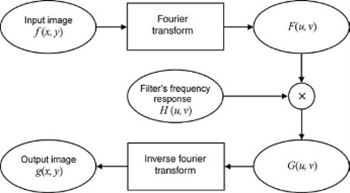

When executing frequency domain operations, it is crucial to align the dimensions of the Fourier transforms involved. Padding may be required to ensure compatibility for pointwise multiplication. The choice of the convolution kernel $ H(u, v) $ is pivotal and should be carefully designed to achieve the desired filtering effect.

Frequency domain operations are a staple in image processing, offering a different perspective for classical operations. Filters designed in the spatial domain have their counterparts in the frequency domain, often with increased efficiency and interpretability.

In practice, images are stored in the spatial domain; thus, to leverage the power of frequency domain processing, we must:

1. Transform the image to the frequency domain using the Fourier Transform.
2. Apply the desired frequency domain filter.
3. Return the image to the spatial domain with the inverse Fourier Transform.

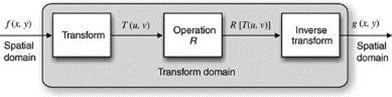
This structured approach allows for a diverse range of operations to be performed with precision and efficiency.
In Python,the two-dimensional Fourier Transform of an image and its inverse can be obtained using the NumPy library, numpy.fft.fft2 and numpy.fft.ifft2, respectively.
 For visualization purposes, the frequency spectrum can be centered using numpy.fft.fftshift, and the original position can be restored with numpy.fft.ifftshift.

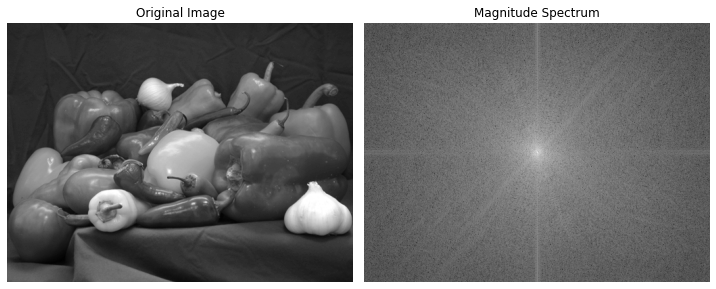

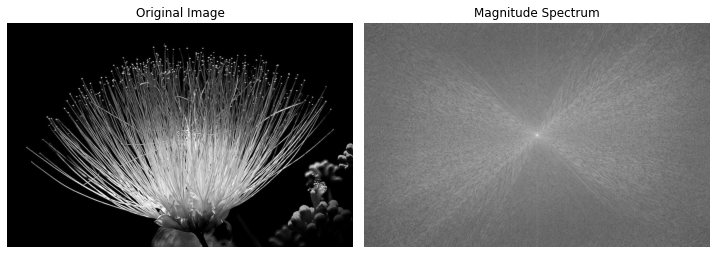

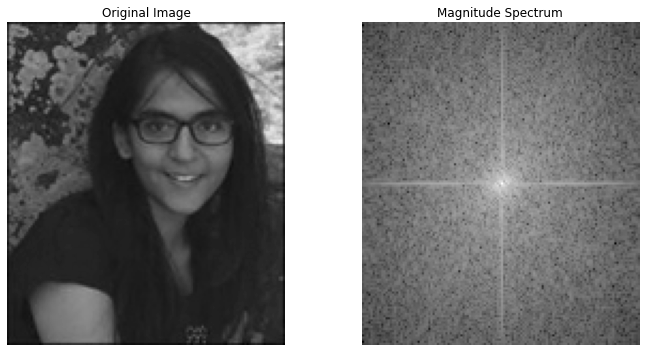

In [2]:
images = [veg_img, flower_img, girl_img]
images_np = [np.array(image) for image in images]

# Apply the 2D Fourier Transform and shift the zero frequency component to the center
f_transforms = [np.fft.fftshift(np.fft.fft2(img_np)) for img_np in images_np]

# Calculate the magnitude spectrum, normalize, and convert to a log scale for better visualization
magnitude_spectrums = [20 * np.log(np.abs(f_transform)) for f_transform in f_transforms]

# Display the original images and their magnitude spectrums using the show_images function
for i in range(len(images_np)):
    show_images([images_np[i], magnitude_spectrums[i]], ['Original Image', 'Magnitude Spectrum'], cmap='gray')

### 5.2 Low-Pass Filtering in Frequency Domain

Low-pass filters are used in image processing to reduce high-frequency components, such as noise and edges, while preserving low-frequency components like the general structure or background. The result is a smoother version of the original image, often perceived as blurred. There are several types of low-pass filters, each with different characteristics:

1. **Ideal Low-pass filter (ILPF):** Provides a sharp cutoff at a certain frequency. It preserves all frequencies below a threshold (the cutoff frequency) and eliminates all frequencies above.

2. **Butterworth Low-pass filter (BLPF):** Offers a smoother transition than ILPF. The filter does not have a sharp cutoff; the transition is gradual.

3. **Gaussian Low-pass filter (GLPF):** The transition is even smoother than BLPF, following a Gaussian curve.

#### 5.2.1 Ideal Low-pass Filter (ILPF)

The Ideal Low-pass Filter (ILPF) operates by maintaining frequency components within a specified radius $ D_0 $ from the center of the Fourier Transform and attenuating components outside this radius. Mathematically, the transfer function $ H(u, v) $ of an ILPF is defined as:

$$
H(u, v) =
  \begin{cases} 
   1 & \text{if } D(u, v) \leq D_0 \\
   0 & \text{if } D(u, v) > D_0
  \end{cases}
$$

Here, $ D(u, v) $ is the Euclidean distance from the center of the frequency spectrum, and $ D_0 $ is the cutoff frequency, determining the extent of the filtering effect.

The sharp transition of ILPF is not always desirable as it can introduce artifacts in the reconstructed image, a phenomenon known as ringing effects due to the Gibbs phenomenon.

This Python code provides a foundational structure for implementing an Ideal Low-pass Filter and applying it to an image. The visualization includes both the filtered image and the filter itself in the frequency domain.

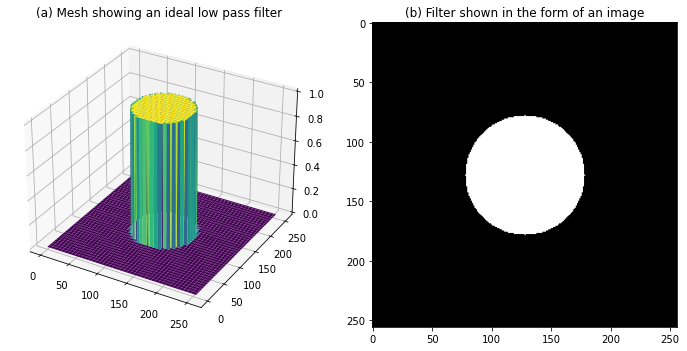

In [3]:
# Define the ideal low pass filter function
def ideal_low_pass_filter(size, cutoff):
    center = (size[0] // 2, size[1] // 2)
    H = np.zeros(size)
    for u in range(size[0]):
        for v in range(size[1]):
            if (u - center[0])**2 + (v - center[1])**2 <= cutoff**2:
                H[u, v] = 1
    return H

# Filter size and cutoff frequency
size = (256, 256)
cutoff = 50  # Example cutoff frequency

# Generate the ideal low pass filter
H = ideal_low_pass_filter(size, cutoff)

# Create a meshgrid for visualization
x = np.linspace(0, size[0]-1, size[0])
y = np.linspace(0, size[1]-1, size[1])
X, Y = np.meshgrid(x, y)

# Plot the 3D mesh visualization of the filter
fig = plt.figure(figsize=(12, 6))

# 3D plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, H, cmap='viridis')
ax1.set_title('(a) Mesh showing an ideal low pass filter')

# 2D plot of the filter
ax2 = fig.add_subplot(122)
ax2.imshow(H, cmap='gray')
ax2.set_title('(b) Filter shown in the form of an image')

plt.show()


The code above defines an ideal low-pass filter function and generates a 3D surface plot along with a 2D grayscale image of the filter. It uses matplotlib for plotting, and mpl_toolkits.mplot3d for 3D plotting capabilities. The filter is radially symmetric with a sharp cutoff at the specified frequency. The 3D mesh shows the shape of the filter in the frequency domain, while the 2D image provides a spatial domain representation.

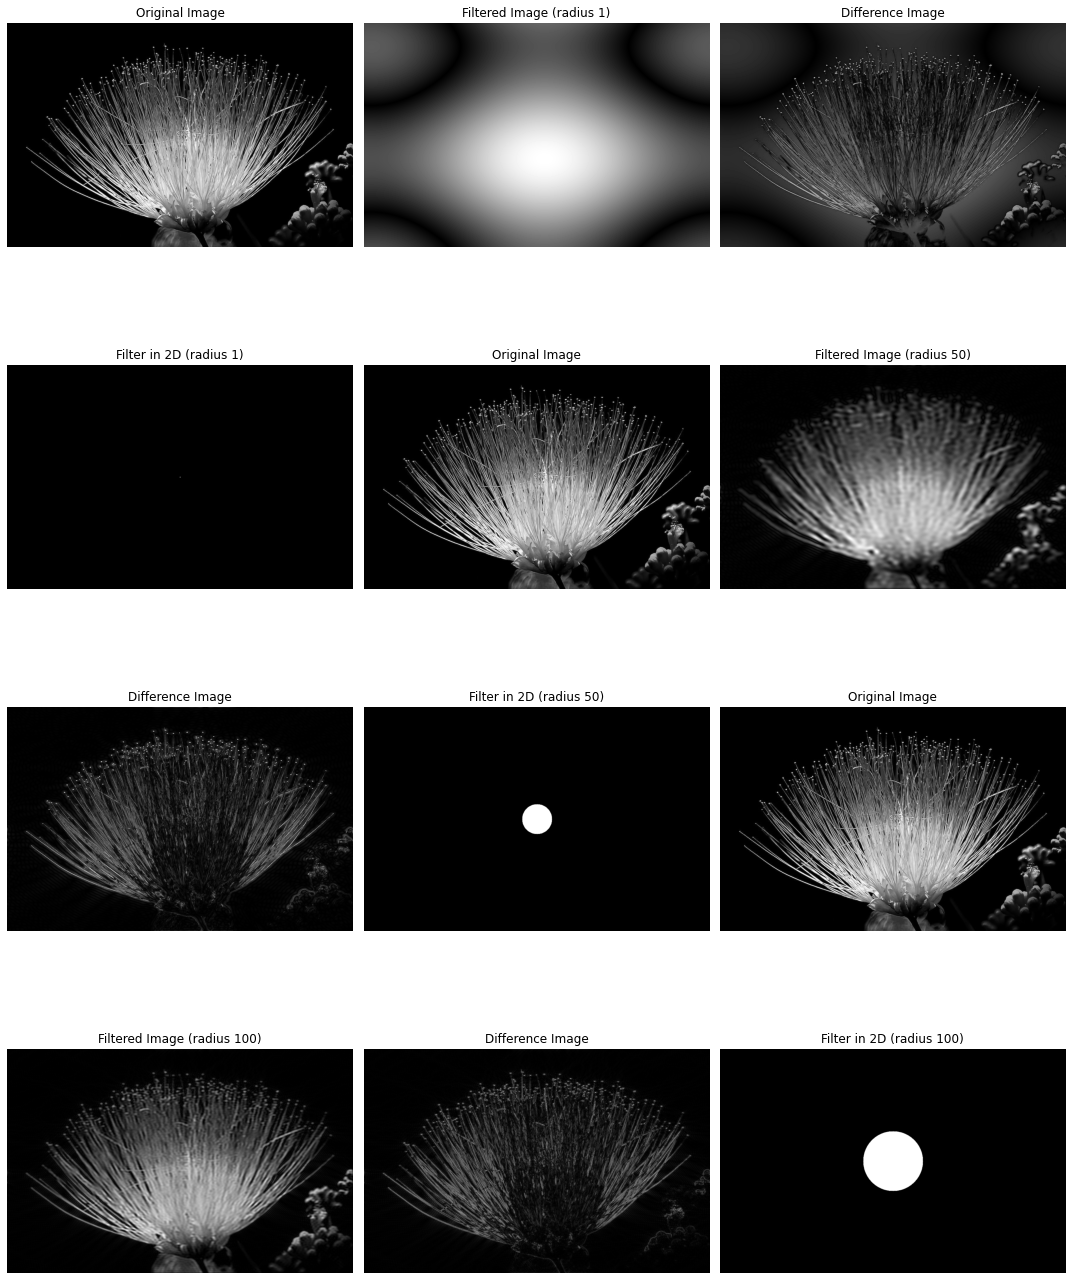

In [4]:
# Apply the 2D Fourier Transform and shift the zero frequency component to the center
f_transform = fftshift(fft2(flower_img))

# Define cutoff frequencies for demonstration
cutoffs = [1, 50, 100]

# Apply Ideal Low Pass Filter with different radii and visualize the results
output_images = []
output_titles = []
for cutoff in cutoffs:
    # Create the ideal low pass filter
    H = ideal_low_pass_filter(flower_img.shape, cutoff)

    # Apply the filter to the Fourier transformed image
    filtered_f_transform = f_transform * H

    # Apply the Inverse 2D Fourier Transform
    filtered_img = np.abs(ifft2(ifftshift(filtered_f_transform)))

    # Calculate the difference image
    difference_img = np.abs(flower_img - filtered_img)

    # Append to the output lists
    output_images.extend([flower_img, filtered_img, difference_img, H])
    output_titles.extend([
        "Original Image",
        f"Filtered Image (radius {cutoff})",
        "Difference Image",
        f"Filter in 2D (radius {cutoff})"
    ])

# Display the original images, filtered images, difference images, and filters
show_images(output_images, output_titles, cmap='gray')


### 5.2.2 Butterworth Low-pass Filter (BLPF)

The Butterworth Low-Pass Filter offers a smooth frequency response with a transition that becomes steeper as the order of the filter, denoted as $ n $, increases. Unlike the Ideal Low-Pass Filter, which has a sharp cutoff, the Butterworth filter has a more gradual roll-off, providing a smoother transition from passband to stopband. This makes it a popular choice in image processing to reduce the ringing artifacts that can be introduced by sharp transitions.

Mathematically, the Butterworth filter's transfer function \( H(u, v) \) is defined as:

$$
H(u, v) = \frac{1}{1 + \left(\frac{D(u, v)}{D_0}\right)^{2n}}
$$

where $ D(u, v) $ is the distance from the point $ (u, v) $ to the center of the frequency spectrum, and $ D_0 $ is the cutoff frequency. The parameter $ n $ controls the steepness of the filter's transition. A higher $ n $ results in a response that more closely approximates that of an Ideal Low-Pass Filter.

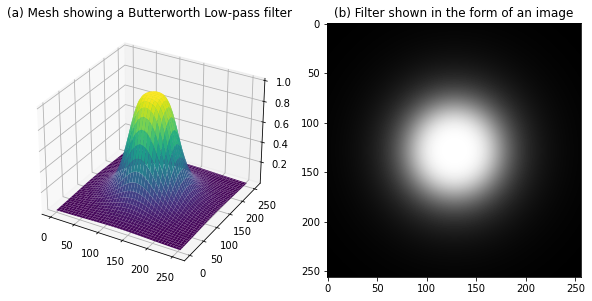

In [5]:
def butterworth_low_pass_filter(size, cutoff, n):
    """Create a Butterworth low-pass filter."""
    H = np.zeros(size)
    center = (size[0] // 2, size[1] // 2)
    for u in range(size[0]):
        for v in range(size[1]):
            D = np.sqrt((u - center[0]) ** 2 + (v - center[1]) ** 2)
            H[u, v] = 1 / (1 + (D / cutoff) ** (2 * n))
    return H

# Filter parameters
size = (256, 256)
cutoff = 50  # Cutoff frequency
n = 2  # Order of the filter

# Generate the Butterworth low-pass filter
H = butterworth_low_pass_filter(size, cutoff, n)

# Create a meshgrid for plotting
x = np.arange(0, size[1])
y = np.arange(0, size[0])
X, Y = np.meshgrid(x, y)

# Plot the filter as a 3D mesh
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, H, cmap='viridis')
ax.set_title('(a) Mesh showing a Butterworth Low-pass filter')

# Plot the filter as a 2D image
ax2 = fig.add_subplot(122)
ax2.imshow(H, cmap='gray')
ax2.set_title('(b) Filter shown in the form of an image')
plt.show()


The code above visualizes how the Butterworth low-pass filter looks in the frequency domain, showing its smooth transition from low frequencies (passband) to high frequencies (stopband). The 3D mesh plot gives a sense of the filter's gradual roll-off, while the 2D image shows how the filter would appear as a grayscale image, with brighter areas representing higher filter values (greater transmission) and darker areas representing lower values (greater attenuation).

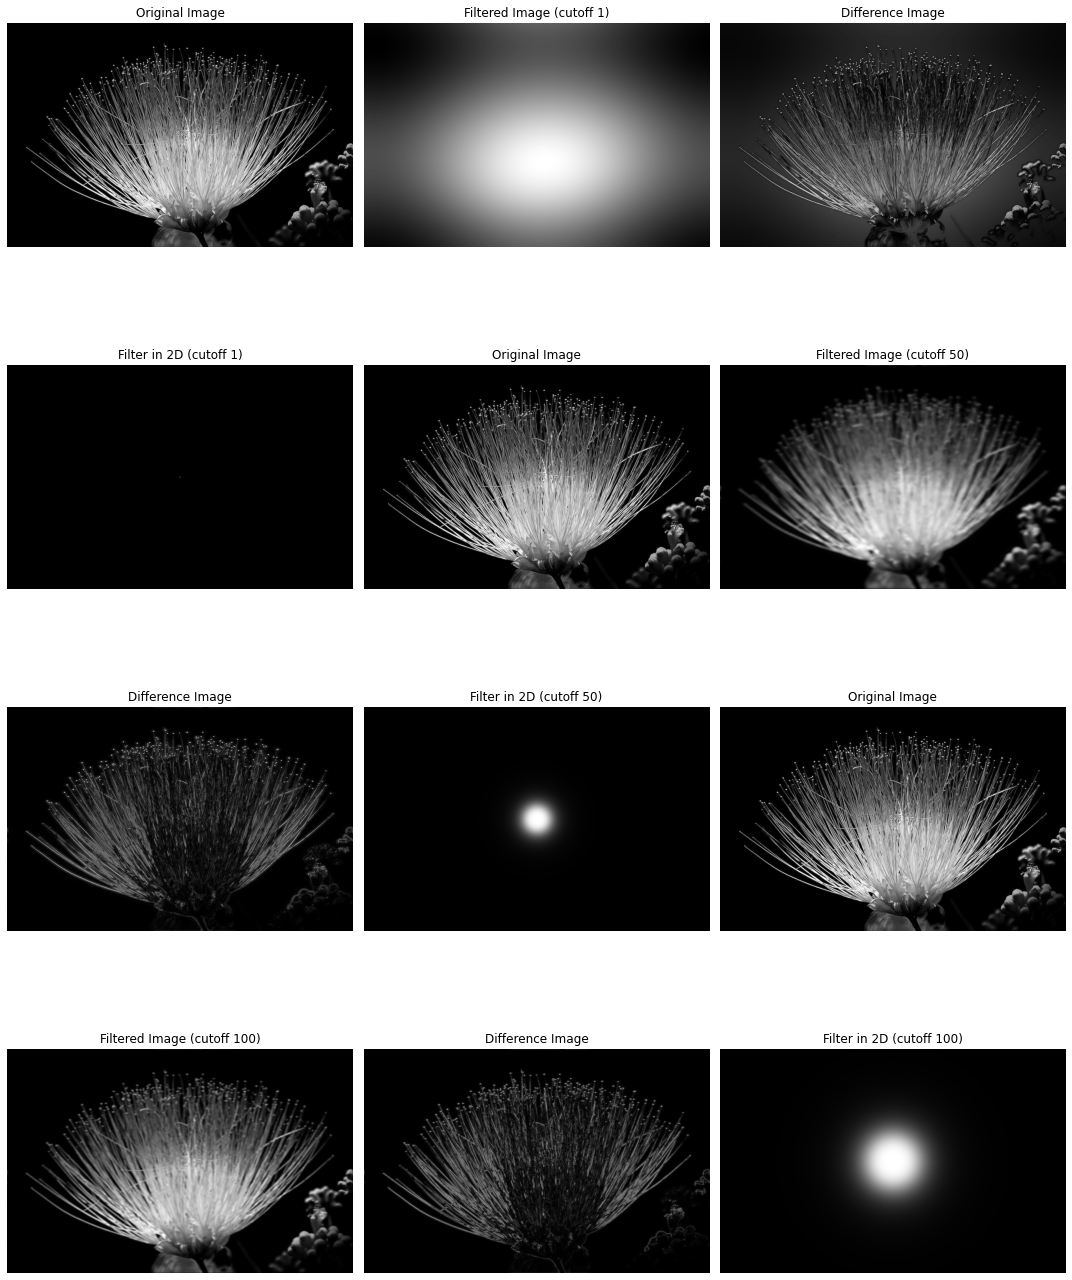

In [6]:
# Define the Butterworth low pass filter function
def butterworth_low_pass_filter(size, cutoff, n):
    H = np.zeros(size)
    center = (size[0] // 2, size[1] // 2)
    for u in range(size[0]):
        for v in range(size[1]):
            D_uv = np.sqrt((u - center[0])**2 + (v - center[1])**2)
            H[u, v] = 1 / (1 + (D_uv / cutoff)**(2 * n))
    return H

# Apply the 2D Fourier Transform and shift the zero frequency component to the center
f_transform = fftshift(fft2(flower_img))

# Define cutoff frequencies and filter order for demonstration
cutoffs = [1, 50, 100]
filter_order = 2  # You can change this value to apply different orders of the filter

# Apply Butterworth Low Pass Filter with different radii and visualize the results
output_images = []
output_titles = []
for cutoff in cutoffs:
    # Create the Butterworth low pass filter
    H = butterworth_low_pass_filter(flower_img.shape, cutoff, filter_order)

    # Apply the filter to the Fourier transformed image
    filtered_f_transform = f_transform * H

    # Apply the Inverse 2D Fourier Transform
    filtered_img = np.abs(ifft2(ifftshift(filtered_f_transform)))

    # Calculate the difference image
    difference_img = np.abs(flower_img - filtered_img)

    # Append to the output lists
    output_images.extend([flower_img, filtered_img, difference_img, H])
    output_titles.extend([
        "Original Image",
        f"Filtered Image (cutoff {cutoff})",
        "Difference Image",
        f"Filter in 2D (cutoff {cutoff})"
    ])

# Display the original images, filtered images, difference images, and filters
show_images(output_images, output_titles, cmap='gray')


### 5.3 High-Pass Filtering
A high-pass filter (HPF) is designed to pass high frequencies and attenuate frequencies lower than the cutoff frequency, $ D_0 $. The high-pass filter can be obtained by subtracting the low-pass filter (LPF) from an all-pass filter (which theoretically passes all frequencies). Mathematically, this can be represented as:

$$ \text{HPF}(u, v) = 1 - \text{LPF}(u, v) $$

### 5.3.1 Ideal High-Pass Filter (IHPF)
An Ideal High-pass filter attenuates all frequency components within a specified radius (from the center of the Fourier transform), while enhancing all others. Mathematically, an Ideal High-pass Filter can be described as:

$$
H(u, v) = 
  \begin{cases} 
   0 & \text{if } D(u, v) \leq D_0 \\
   1 & \text{if } D(u, v) > D_0 
  \end{cases}
$$

where \( D(u,v) \) is the Euclidean distance from the center of the frequency domain (origin of the Fourier transform), given by:

$$ D(u, v) = \sqrt{(u - M/2)^2 + (v - N/2)^2} $$

for an image of size $ M \times N $.

An Ideal High-Pass Filter behaves oppositely to an Ideal Low-Pass Filter as it sets all frequencies inside the defined radius to zero, while passing frequencies outside the circle. It is not possible to implement IHPF in hardware. 

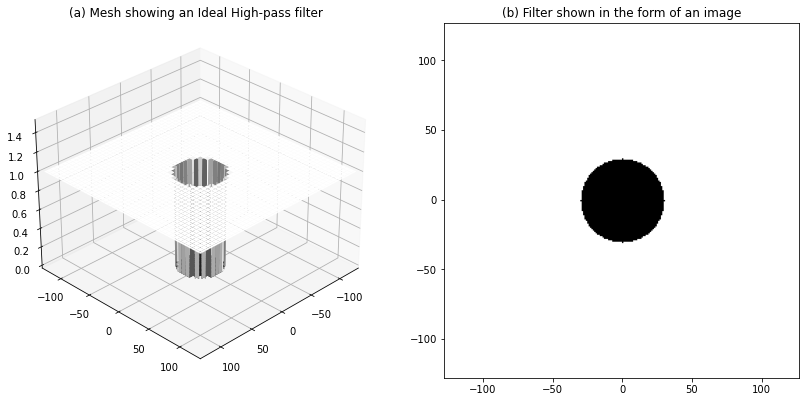

In [7]:
# Define the meshgrid
x = np.linspace(-128, 127, 256)
y = np.linspace(-128, 127, 256)
X, Y = np.meshgrid(x, y)
Z = np.sqrt(X**2 + Y**2)

# Create the Ideal High-pass filter mask
radius = 30  # Assuming a cutoff frequency radius
H = np.ones_like(Z)
H[Z <= radius] = 0

# Plotting the mesh showing the Ideal High-pass filter
fig = plt.figure(figsize=(14, 7))

# Mesh plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, H, cmap='gray')
ax1.set_title('(a) Mesh showing an Ideal High-pass filter')
ax1.set_xlim([-128, 127])
ax1.set_ylim([-128, 127])
ax1.set_zlim([0, 1.5])
ax1.view_init(30, 45)

# Image plot
ax2 = fig.add_subplot(122)
ax2.imshow(H, cmap='gray', extent=(-128, 127, -128, 127))
ax2.set_title('(b) Filter shown in the form of an image')

plt.show()


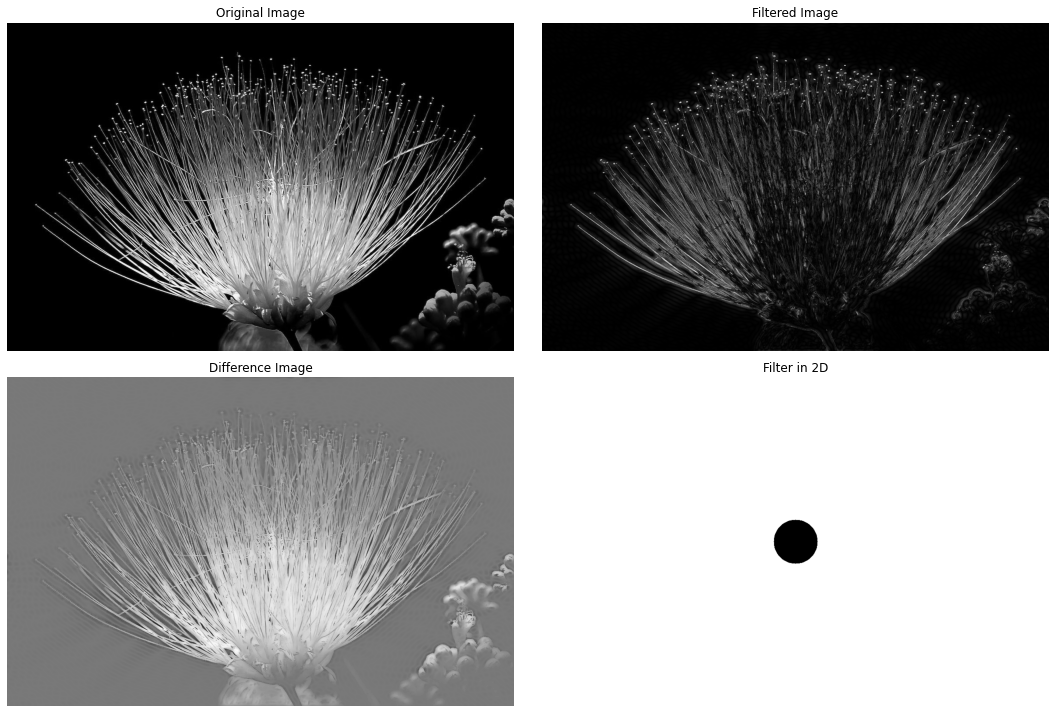

Effect of Ideal High-pass filter with radius 50


In [8]:
def ideal_high_pass_filter(rows, cols, radius):
    """
    Create an ideal high-pass filter with a specified radius.
    :param rows: Number of rows in the filter.
    :param cols: Number of columns in the filter.
    :param radius: Radius for the high-pass filter.
    :return: 2D high-pass filter.
    """
    x, y = np.ogrid[:rows, :cols]
    center_row, center_col = rows // 2, cols // 2
    distance_from_center = np.sqrt((x - center_row)**2 + (y - center_col)**2)
    mask = distance_from_center > radius
    return mask

def apply_ideal_high_pass(im, radius):
    """
    Apply an ideal high-pass filter to an image.
    :param im: Input image.
    :param radius: Radius of the high-pass filter.
    :return: Filtered image and the high-pass filter.
    """
    rows, cols = im.shape
    imf = fftshift(fft2(im))
    hpf = ideal_high_pass_filter(rows, cols, radius)
    outf = imf * hpf
    out = np.abs(ifft2(outf))
    return out, hpf

radius = 50 # Define the radius for the high-pass filter

filtered_image, filter_visualization = apply_ideal_high_pass(flower_img, radius)

# Calculate the difference image
difference_image = flower_img - filtered_image

# Display the original image, filtered image, and the filter
show_images([flower_img, filtered_image, difference_image, filter_visualization], 
            ['Original Image', 'Filtered Image', 'Difference Image', 'Filter in 2D'], images_per_row=2)
print("Effect of Ideal High-pass filter with radius 50")

###  5.3.2  Butterworth High-Pass Filter
The Butterworth high-pass filter is designed to have a frequency response that is as flat as possible in the passband. It avoids the ripples in the frequency response characteristic of the ideal high-pass filter. The mathematical representation of a 2D Butterworth high-pass filter $ H(u, v) $ is:

$$
H(u, v) = \frac{1}{1 + \left(\frac{D_0}{D(u, v)}\right)^{2n}}
$$

Where:
- $ D(u, v) $ is the distance from the point $(u, v) $ in the frequency domain to the center of the frequency rectangle.
- $ D_0 $ is the cutoff frequency.
- $ n $ is the order of the filter.

The distance $D(u, v)$ is typically calculated as:

$$
D(u, v) = \sqrt{(u - u_0)^2 + (v - v_0)^2}
$$

Here, $(u_0, v_0)$ represents the center of the frequency domain.

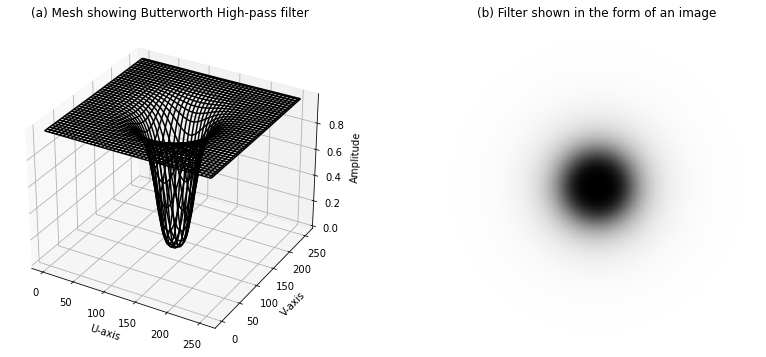

In [9]:
def butterworth_high_pass_filter(rows, cols, cutoff, order):
    """
    Create a Butterworth high-pass filter with a specified cutoff frequency and order.
    :param rows: Number of rows in the filter.
    :param cols: Number of columns in the filter.
    :param cutoff: Cutoff frequency (radius) for the high-pass filter.
    :param order: Order of the Butterworth filter.
    :return: 2D Butterworth high-pass filter.
    """
    x, y = np.ogrid[:rows, :cols]
    center_row, center_col = rows // 2, cols // 2
    distance_from_center = np.sqrt((x - center_row)**2 + (y - center_col)**2)
    # Correct mask for a high-pass filter
    mask = 1 - 1 / (1 + (distance_from_center / cutoff)**(2 * order))
    return mask

# Define the size of the filter and parameters
rows, cols = 256, 256
cutoff_frequency = 30  # Cutoff frequency (radius)
order = 2  # Order of the Butterworth filter

# Create the Butterworth high-pass filter
hpf = butterworth_high_pass_filter(rows, cols, cutoff_frequency, order)

# Plot the 3D mesh of the filter
fig = plt.figure(figsize=(14, 6))

# 3D plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
u = np.linspace(0, rows-1, rows)
v = np.linspace(0, cols-1, cols)
U, V = np.meshgrid(u, v)
ax.plot_wireframe(U, V, hpf, color='black')
ax.set_title('(a) Mesh showing Butterworth High-pass filter')
ax.set_xlabel('U-axis')
ax.set_ylabel('V-axis')
ax.set_zlabel('Amplitude')

# 2D plot
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(hpf, cmap='gray')
ax2.set_title('(b) Filter shown in the form of an image')
ax2.axis('off')

plt.show()

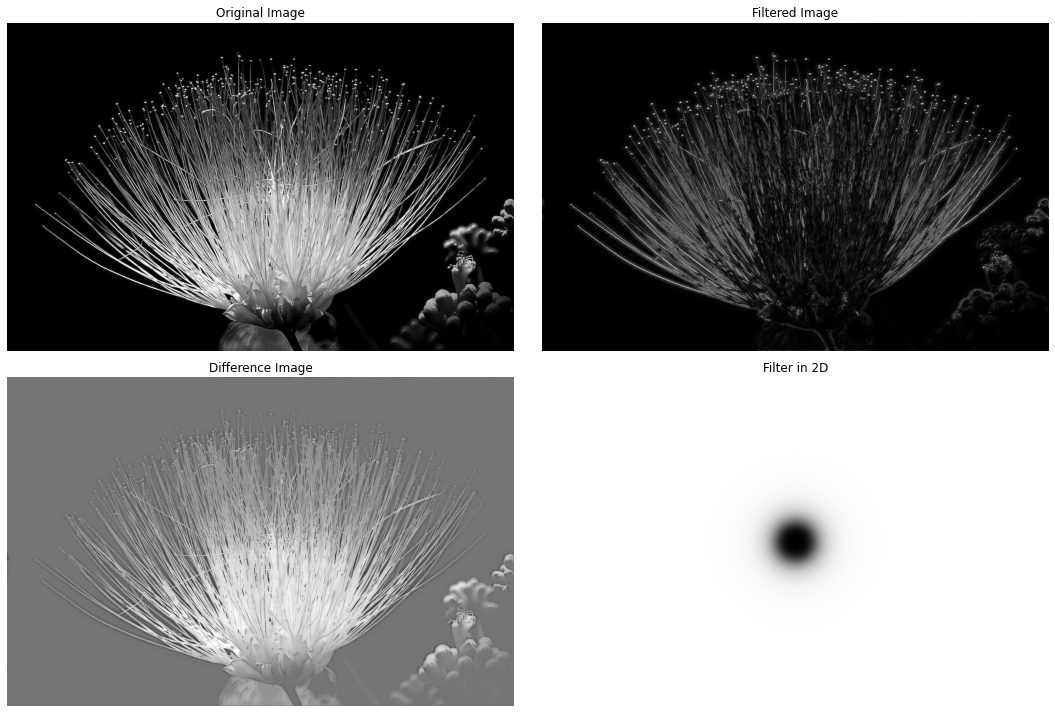

Effect of Butterworth High-pass filter with radius 50


In [10]:
def butterworth_high_pass_filter(rows, cols, cutoff, order):
    """
    Create a Butterworth high-pass filter with a specified cutoff frequency and order.
    :param rows: Number of rows in the filter.
    :param cols: Number of columns in the filter.
    :param cutoff: Cutoff frequency (radius) for the high-pass filter.
    :param order: Order of the Butterworth filter.
    :return: 2D Butterworth high-pass filter.
    """
    x, y = np.ogrid[:rows, :cols]
    center_row, center_col = rows // 2, cols // 2
    distance_from_center = np.sqrt((x - center_row)**2 + (y - center_col)**2)
    mask = 1 / (1 + (cutoff / (distance_from_center + 1e-5))**(2 * order))
    return mask

def apply_butterworth_high_pass(im, cutoff, order):
    """
    Apply a Butterworth high-pass filter to an image.
    :param im: Input image.
    :param cutoff: Cutoff frequency (radius) of the high-pass filter.
    :param order: Order of the Butterworth filter.
    :return: Filtered image.
    """
    rows, cols = im.shape
    imf = fftshift(fft2(im))
    bpf = butterworth_high_pass_filter(rows, cols, cutoff, order)
    outf = imf * bpf
    out = np.abs(ifft2(outf))
    return out, bpf


cutoff_frequency = 50  # Define the cutoff frequency (radius)
order = 2  # Order of the filter

filtered_image, filter_visualization = apply_butterworth_high_pass(flower_img, cutoff_frequency, order)

# Calculate the difference image
difference_image = flower_img - filtered_image

# Display the original image, filtered image, and the filter
show_images([flower_img, filtered_image, difference_image, filter_visualization], 
            ['Original Image', 'Filtered Image', 'Difference Image', 'Filter in 2D'], images_per_row=2)
print("Effect of Butterworth High-pass filter with radius 50")

###  5.3.3  Gaussian High-Pass Filter
The Gaussian High-pass filter (GHPF) is used to attenuate low-frequency components of a signal or image while preserving or passing high-frequency components. This behavior is essentially the opposite of a Gaussian Low-pass filter (GLPF), which attenuates high frequencies. The mathematical representation of a GHPF in the frequency domain is given by:

$$H(u, v) = 1 - \exp\left(-\frac{D^2(u, v)}{2\sigma^2}\right) $$

Where:
- $H(u, v) $ is the value of the high-pass filter at coordinates \( (u, v) \) in the frequency domain.
- $ D(u, v) $ is the Euclidean distance from the center of the frequency domain (the origin in the Fourier transform space) to the point \( (u, v) \).
- $ \sigma $ (the Greek letter sigma) represents the standard deviation of the Gaussian curve, which controls the cutoff frequency of the filter. A smaller \( \sigma \) results in a narrower peak in the frequency domain, attenuating more frequencies.

The Euclidean distance \( D(u, v) \) is defined as:

$$ D(u, v) = \sqrt{(u - u_0)^2 + (v - v_0)^2} $$

where $ (u_0, v_0) $ represents the center of the frequency domain.

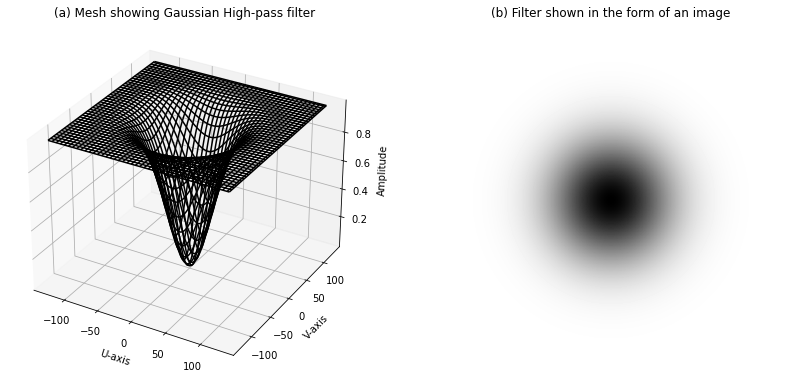

In [11]:
def gaussian_high_pass_filter(size, cutoff):
    """
    Create a Gaussian high-pass filter with a specified cutoff frequency.
    :param size: Size of the filter (it's a square, so only one dimension is needed).
    :param cutoff: Cutoff frequency (standard deviation) for the high-pass filter.
    :return: 2D Gaussian high-pass filter.
    """
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)
    d = np.sqrt(x**2 + y**2)
    gaussian = np.exp(-(d**2) / (2 * (cutoff**2)))
    gaussian_high_pass = 1 - gaussian  # Subtract the Gaussian from 1 for high-pass
    return gaussian_high_pass

# Define the size of the filter and the cutoff frequency
size = 256  # Size of the filter
cutoff_frequency = 30  # Cutoff frequency (standard deviation)

# Create the Gaussian high-pass filter
ghpf = gaussian_high_pass_filter(size, cutoff_frequency)

# Normalize the filter for display purposes
ghpf_normalized = (ghpf - np.min(ghpf)) / (np.max(ghpf) - np.min(ghpf))

# Plot the 3D mesh of the filter
fig = plt.figure(figsize=(14, 7))

# 3D plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
x = np.linspace(-size // 2, size // 2, size)
y = np.linspace(-size // 2, size // 2, size)
X, Y = np.meshgrid(x, y)
ax1.plot_wireframe(X, Y, ghpf, color='black')
ax1.set_title('(a) Mesh showing Gaussian High-pass filter')
ax1.set_xlabel('U-axis')
ax1.set_ylabel('V-axis')
ax1.set_zlabel('Amplitude')

# 2D plot
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(ghpf_normalized, cmap='gray')
ax2.set_title('(b) Filter shown in the form of an image')
ax2.axis('off')

plt.show()

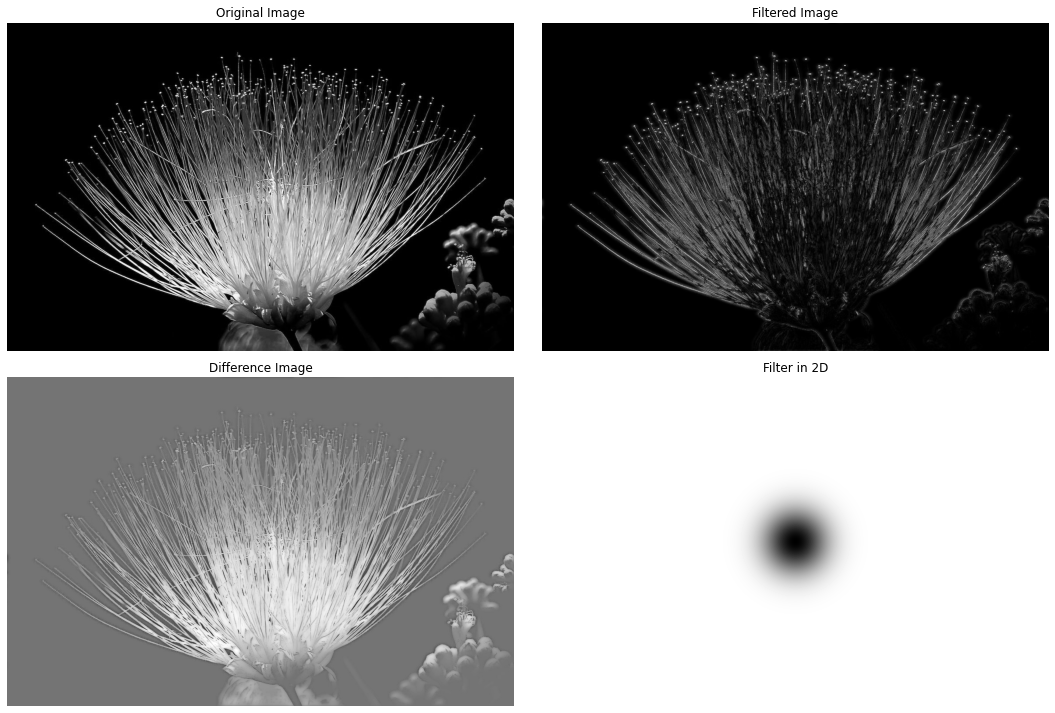

Effect of Gaussian High-pass filter with sigma 50


In [12]:
def gaussian_high_pass_filter(rows, cols, sigma):
    """
    Create a Gaussian high-pass filter with a specified standard deviation.
    :param rows: Number of rows in the filter.
    :param cols: Number of columns in the filter.
    :param sigma: Standard deviation for the Gaussian high-pass filter.
    :return: 2D Gaussian high-pass filter.
    """
    x = np.linspace(-cols//2, cols//2, cols)
    y = np.linspace(-rows//2, rows//2, rows)
    x, y = np.meshgrid(x, y)
    d = np.sqrt(x**2 + y**2)
    gaussian = np.exp(-(d**2) / (2 * sigma**2))
    return 1 - gaussian  # Subtracting from 1 gives the high-pass filter

def apply_gaussian_high_pass(im, sigma):
    """
    Apply a Gaussian high-pass filter to an image.
    :param im: Input image.
    :param sigma: Standard deviation for the Gaussian high-pass filter.
    :return: Filtered image and the high-pass filter.
    """
    rows, cols = im.shape
    imf = fftshift(fft2(im))
    ghp = gaussian_high_pass_filter(rows, cols, sigma)
    outf = imf * ghp
    out = np.abs(ifft2(outf))
    return out, ghp

sigma = 50  # The standard deviation for the Gaussian high-pass filter

# Apply the Gaussian high-pass filter
filtered_image, filter_visualization = apply_gaussian_high_pass(flower_img, sigma)

# Calculate the difference image
difference_image = flower_img - filtered_image

# Display the original image, filtered image, and the filter
show_images([flower_img, filtered_image, difference_image, filter_visualization], 
            ['Original Image', 'Filtered Image', 'Difference Image', 'Filter in 2D'], images_per_row=2)
print("Effect of Gaussian High-pass filter with sigma 50")


### Summarry of high pass filtering
The Gaussian High-Pass Filter, Butterworth High-Pass Filter, and Ideal High-Pass Filter are all types of high-pass filters used in signal processing and image processing to allow high-frequency components to pass while attenuating low-frequency components. However, they differ in how they transition from the passband (high frequencies that are allowed to pass) to the stopband (low frequencies that are attenuated).

Here are the key differences:

1. **Ideal High-Pass Filter:**
   - The Ideal High-Pass Filter has a sharp cutoff at a certain frequency called the cutoff frequency. Frequencies higher than the cutoff are passed with full amplitude, while frequencies lower are completely blocked.
   - It is represented mathematically as a rectangular function in the frequency domain.
   - The abrupt transition can lead to ringing artifacts in the processed signal or image due to the Gibbs phenomenon.
   - It is not often used in practical applications due to its unrealistically sharp transition and the artifacts it introduces.

2. **Butterworth High-Pass Filter:**
   - The Butterworth High-Pass Filter has a smoother transition compared to the Ideal filter. It is designed to have a maximally flat frequency response in the passband, meaning no ripples.
   - The transition from passband to stopband is more gradual, with the steepness of the transition determined by the order of the filter. A higher order results in a steeper transition that more closely approximates the Ideal filter.
   - Mathematically, it uses a polynomial function to define the filter's frequency response.
   - The Butterworth filter is a compromise between the Ideal and the Gaussian filters, providing a balance between sharpness of the cutoff and minimization of artifacts.

3. **Gaussian High-Pass Filter:**
   - The Gaussian High-Pass Filter uses a Gaussian function for the transition between passband and stopband. It provides the smoothest transition of the three.
   - This type of filter does not have a sharp cutoff. Instead, frequencies are gradually attenuated starting at low frequencies and continuing into the higher frequencies, following a Gaussian curve.
   - The smooth transition of the Gaussian filter avoids ringing artifacts but may not block low-frequency components as effectively as the Ideal or Butterworth filters.
   - The Gaussian filter is often used in image processing because its response is more natural and less prone to artifacts.

In practical applications, the choice among these filters depends on the requirements for the steepness of the transition and the allowable level of artifacts in the output signal or image. The Ideal filter, while theoretically simple, is less practical due to its abrupt transition causing artifacts. The Butterworth and Gaussian filters are more commonly used, with the Butterworth filter providing a middle ground between the sharp transition of the Ideal filter and the smooth transition of the Gaussian filter.

### 5.4 High-Frequency Emphasis Filter
High-frequency emphasis filtering is a process designed to enhance certain features of an image by boosting its high-frequency components without completely discarding its low-frequency components. This technique can be particularly useful in image processing applications such as edge enhancement, sharpening, and in improving the visibility of fine details.

Mathematically, the high-frequency emphasis filter (HFEF) can be expressed as:

$$ HFEF(u, v) = a + b \cdot HPF(u, v) $$

Here:
- $ HFEF(u, v) $ is the high-frequency emphasis filter at a point $(u, v) $.
- $ a $ is the offset constant, which determines how much of the original image is preserved.
- $ b $ is the multiplier constant, which determines the degree of high-frequency enhancement.
- $ HPF(u, v) $ is the high-pass filter at a point $ (u, v) $.

The constants $ a $ and $ b $ are chosen based on the desired level of emphasis. For example:
- If $a = 1 $ and $ b = 0 $, the filter has no effect on the image.
- If $ a = 0 $ and $ b = 1 $, the filter acts as a standard high-pass filter.
- If $a = 1 $ and $ b > 0 $, the filter preserves the original image and adds an enhanced version of the high-frequency components.